In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
carpeta = os.getcwd()+'/'

G = nx.read_gml(carpeta+'dolphins.gml')

gender = pd.read_csv(carpeta+'dolphinsGender.txt', sep='\t', header=None)
delfines = gender[0] # nombres de delfines (nodos)
genero = gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    G.add_node(d, gender=g)

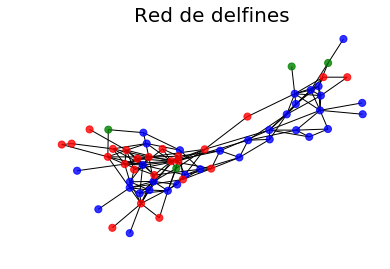

In [3]:
pos = nx.spring_layout(G)

#Nodos
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(),node_color=["blue" if g=="m" else "red" if g=="f" else "green" for g in nx.get_node_attributes(G, "gender").values()],with_labels=False,node_size=50,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(G,pos,width=1.0,alpha=1)

#Etiquetas
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

In [4]:
import community